## Library and Data Import

In [55]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 200)

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 200)

In [3]:
#prepare for the spatial joint and geo data processing
import geopandas as gp
from shapely.geometry import Point, MultiPoint
from fiona.crs import from_epsg
from shapely.geometry import Point
from geopandas.tools import overlay
from geopandas.tools import sjoin

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("seaborn-colorblind")

/Users/shu/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/shu/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Geo mapping set up 

In [5]:
geoVicArea = gp.GeoDataFrame.from_file('DataMapPackage/10minArea/Victoria/10mins_Walking_Victoria.shp')
geoVicArea.head(2)

,Layer,PaperSpace,SubClasses,Linetype,EntityHand,Text,geometry
0,0,0,AcDbEntity:AcDbHatch,,20000,SOLID,"POLYGON ((528298.965220317 179297.747766332, 5..."
1,0,0,AcDbEntity:AcDbHatch,,20001,SOLID,"POLYGON ((528455.334194175 179532.54456059, 52..."


In [6]:
geoVicStation = gp.GeoDataFrame.from_file('DataMapPackage/Plans/Detailed/Geolocated/Victoria/Victoria.shp')
geoVicStation.head(2)

,Layer,PaperSpace,SubClasses,Linetype,EntityHand,Text,geometry
0,Unit detail,0,AcDbEntity:AcDbLine,,3759,,LINESTRING (528878.3295661916 179079.138676800...
1,Unit detail,0,AcDbEntity:AcDbLine,,375A,,LINESTRING (528878.4699253489 179079.071896561...


In [7]:
geoSensors = gp.GeoDataFrame.from_file('DataMapPackage/Sensor/Victoria/SHP/Victoria Sensors.shp')
geoSensors.head(2)

,id,Sens_ID,Sens_NAME,DeviceJOIN,X,Y,JoinNumber,Device,geometry
0,1,1,External entrance to Victoria St,"[26] ""Hudsons Place Ent""",528987.9444,178905.2482,[26],Hudsons Place Ent,POINT (528987.9444966905 178905.2482612658)
1,2,2,Platform 1-2,"[53] ""Platforms 01 - 03 A""",528965.4497,178903.9172,[53],Platforms 01 - 03 A,POINT (528965.4497090809 178903.9172087445)


In [8]:
#set the projection from BNG to 'longlat' format 
geoVicArea['geometry']=geoVicArea['geometry'].to_crs({'proj':'longlat', 
                                                    'ellps':'WGS84', 
                                                    'datum':'WGS84'})
geoSensors['geometry']=geoSensors['geometry'].to_crs({'proj':'longlat', 
                                                    'ellps':'WGS84', 
                                                    'datum':'WGS84'})
geoVicStation['geometry']=geoVicStation['geometry'].to_crs({'proj':'longlat', 
                                                    'ellps':'WGS84', 
                                                    'datum':'WGS84'})

## Voice of the Sensors

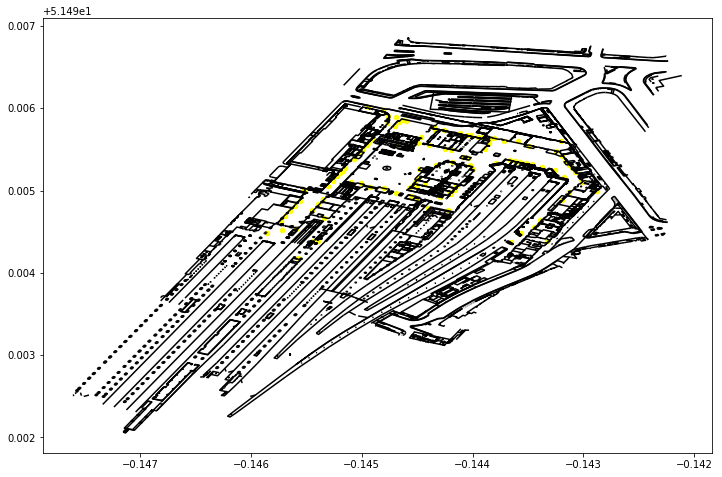

In [61]:
# sensor plot within the station
fig, ax = plt.subplots(1,figsize=(12, 8))
geoVicStation.plot(ax=ax, color='black')
geoSensors.geometry.plot(ax=ax, marker='o', color='yellow', markersize=20)
plt.show();

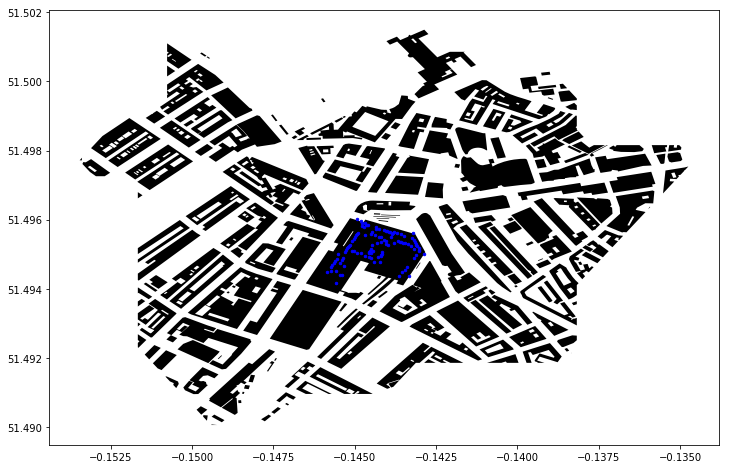

In [10]:
# senor based on the station
fig, ax = plt.subplots(1,figsize=(12, 8))
geoVicArea.plot(ax=ax, color='black')
geoSensors.geometry.plot(ax=ax, marker='o', color='blue', markersize=6)
plt.show();

## Voice of the pedestrain flow

In [11]:
weekdayData = pd.read_csv('DataMapPackage/weekdayData.csv', encoding='utf8')

In [12]:
col_Names=["Time", "UserId", "Latitude", "Longitude","connectionType","deviceLanguage"]
weekdayData= pd.read_csv("DataMapPackage/weekdayData.csv",names=col_Names)

In [13]:
weekdayData['Time'] = pd.to_datetime(weekdayData['Time'], format='%Y-%m-%d %H:%M:%S')

In [14]:
# using device language to subset out all the international passagner 
weekdayDataInter=weekdayData[weekdayData.deviceLanguage!='en-gb']

In [15]:
# Top 20 international device language in June, October, December
# Inferred Top 10 visitor nationality: Italian, Australian, Spanish, French, Hongkong
inter_count = weekdayDataInter.groupby(['deviceLanguage'], as_index=False).connectionType.count()
inter_count.columns = ['InterId', 'Count']
inter_count.sort_values(by='Count',ascending=False).reset_index(drop=True).head(20)

,InterId,Count
0,en-us,100989
1,it-it,16783
2,en-au,15838
3,es-es,11958
4,fr-fr,10932
5,en-it,10413
6,zh-gb,9646
7,ro-ro,8428
8,en-hk,8292
9,en-fr,8252


In [16]:
# grouping data to am, noon, pm
weekdayDataMorn = (weekdayDataInter.set_index('Time')
          .between_time('08:00:00', '09:00:00')
          .reset_index()
          .reindex(columns=weekdayData.columns))
weekdayDataNoon = (weekdayDataInter.set_index('Time')
          .between_time('12:00:00', '13:00:00')
          .reset_index()
          .reindex(columns=weekdayData.columns))
weekdayDataNight = (weekdayDataInter.set_index('Time')
          .between_time('18:00:00', '19:00:00')
          .reset_index()
          .reindex(columns=weekdayData.columns))

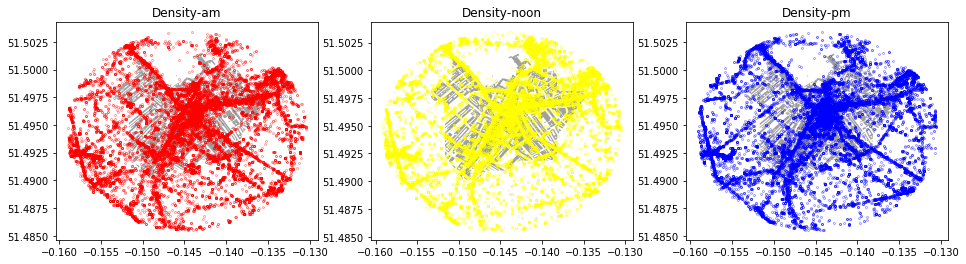

In [17]:
# density plot for different times of the day 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16, 4))

geoVicArea.plot(ax=ax1, color='grey',alpha=0.75)
geoVicArea.plot(ax=ax2, color='grey',alpha=0.75)
geoVicArea.plot(ax=ax3, color='grey',alpha=0.75)

scatter1 = ax1.scatter(weekdayDataMorn['Longitude'], weekdayDataMorn['Latitude'], 
                              marker='o', linewidths=2, c='red', s=0.1)
scatter2 = ax2.scatter(weekdayDataNoon['Longitude'], weekdayDataNoon['Latitude'], 
                              marker='o', linewidths=2, c='yellow', s=0.1)
scatter3 = ax3.scatter(weekdayDataNight['Longitude'], weekdayDataNight['Latitude'], 
                              marker='o', linewidths=2, c='blue', s=0.1)

ax1.set_title("Density-am")
ax2.set_title("Density-noon")
ax3.set_title("Density-pm")

fig.subplots_adjust(hspace=0.5)

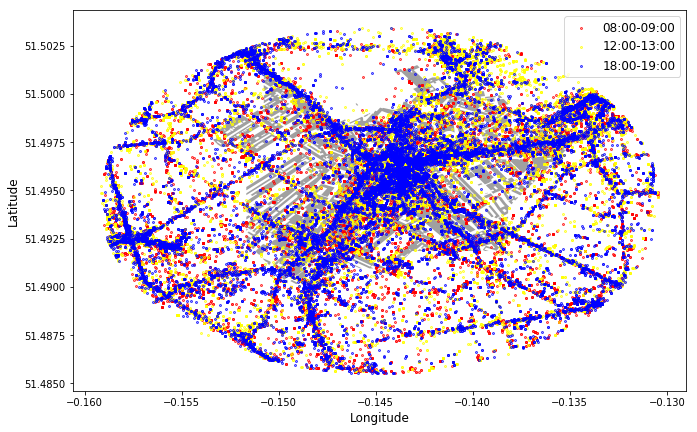

In [54]:
fig, ax = plt.subplots(figsize=(11, 7))

geoVicArea.plot(ax=ax, color='grey',alpha=0.75)
# cluster_scatter = ax.scatter(weekdayData['Longitude'], weekdayData['Latitude'],c=geoSub_filtered.group,
#                          edgecolor='None', alpha=0.25, s=50)
# plt.set_title("Passegner Density in Peak Hour - Victoria Station")

scatter1 = ax.scatter(weekdayDataMorn['Longitude'], weekdayDataMorn['Latitude'], 
                              marker='o', linewidths=2, c='red', s=0.5)
scatter2 = ax.scatter(weekdayDataNoon['Longitude'], weekdayDataNoon['Latitude'], 
                              marker='o', linewidths=2, c='yellow', s=0.5)
scatter3 = ax.scatter(weekdayDataNight['Longitude'], weekdayDataNight['Latitude'], 
                              marker='o', linewidths=2, c='blue', s=0.5)
ax.set_title('', fontsize = 14)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize = 12)
ax.legend([scatter1, scatter2,scatter3],
          ['08:00-09:00', '12:00-13:00','18:00-19:00'], 
          loc='upper right', fontsize = 12)
plt.show();

In [19]:
from sklearn.cluster import DBSCAN
import sklearn.preprocessing as preprocessing
from sklearn import metrics


/Users/shu/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/shu/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [20]:
geoSub=weekdayDataMorn[['Latitude','Longitude']].dropna(axis=0)
scaled = preprocessing.scale(geoSub)

In [21]:
scaled

array([[ 0.99537168,  0.09912502],
       [ 1.22765655,  1.36077405],
       [-1.09907361,  0.0974014 ],
       ...,
       [-2.32525951,  0.67883182],
       [-2.31878973,  0.67164763],
       [ 0.17998765,  0.00731393]])

In [22]:
len(scaled)

28022

In [23]:
dbscan = DBSCAN(eps=0.0000009, min_samples=28) # create DBSCAN cluster object
dbscan.fit(scaled)

DBSCAN(algorithm='auto', eps=9e-07, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=28, n_jobs=1, p=None)

In [24]:
dbscan_labels = dbscan.labels_
num_clusters = len(set(dbscan_labels))
unique_labels = set(dbscan_labels)
num_clusters

5

In [ ]:
#the silhouette_score (0.39) indicates a moderate quality of the computed group
metrics.silhouette_score(scaled, dbscan_labels)

In [25]:
geoSub['group']=dbscan_labels

In [26]:
#here we also try to calculate the centroid of each group
def get_centroid(cluster):
                         cluster_ary = np.asarray(cluster)
                         centroid = cluster_ary.mean(axis=0)
                         return centroid

In [27]:
dbsc_clusters = pd.Series([geoSub[dbscan_labels==n] for n in range(num_clusters)])
cluster_centroids = dbsc_clusters.map(get_centroid)

/Users/shu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/Users/shu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [28]:
cluster_centroids

0    [51.49729240000002, -0.13717250000000003, 0.0]
1    [51.49575805664064, -0.14381666668782445, 1.0]
2    [51.49273681640625, -0.15794078545538176, 2.0]
3     [51.49066162109375, -0.1531990674368813, 3.0]
4                                   [nan, nan, nan]
dtype: object

In [29]:
#unzip the list of centroid points (lat, lon) tuples into separate lat and lon lists
cent_lats, cent_lons, hoge = zip(*cluster_centroids)
centroids_df = pd.DataFrame({'Longitude':cent_lons, 'Latitude':cent_lats})
centroids_df=centroids_df[0:4]

In [30]:
centroids_df

,Longitude,Latitude
0,-0.137173,51.497292
1,-0.143817,51.495758
2,-0.157941,51.492737
3,-0.153199,51.490662


In [33]:
#using the spatial join to get an idea of where the centroids locate
centroids_df_temp=gp.GeoDataFrame({
    'geometry': [Point(x, y) for x, y in zip(centroids_df['Longitude'],centroids_df['Latitude'])],
})
centroids_df_temp.crs=geoVicArea.crs
centroids_df_join=sjoin(centroids_df_temp,geoVicArea,how="inner") 
centroids_df_join

,geometry,index_right,Layer,PaperSpace,SubClasses,Linetype,EntityHand,Text
1,POINT (-0.1438166666878244 51.49575805664064),168,0,0,AcDbEntity:AcDbHatch,,200A8,SOLID


In [34]:
geoSub_filtered = geoSub[geoSub.group>-1]

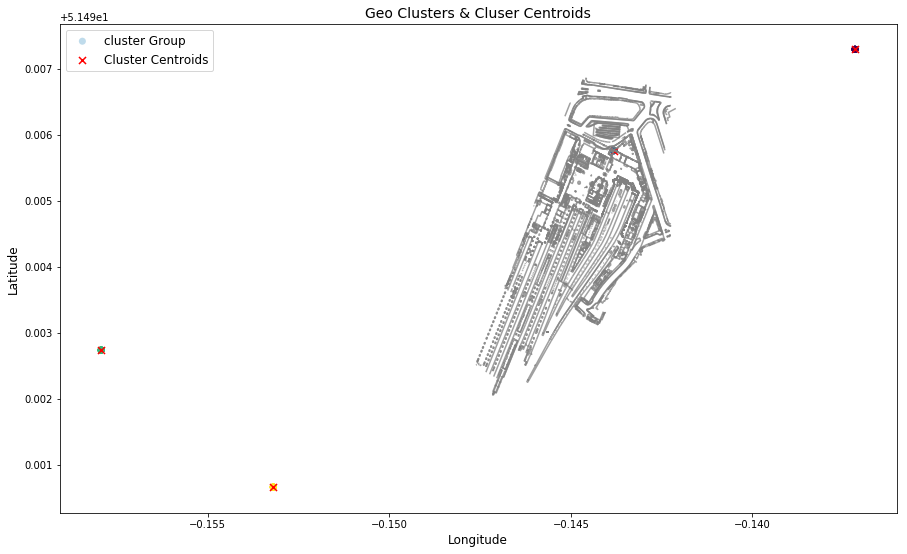

In [37]:
fig, ax = plt.subplots(figsize=(15, 9))

geoVicStation.plot(ax=ax, color='grey',alpha=0.75)
cluster_scatter = ax.scatter(geoSub_filtered['Longitude'], geoSub_filtered['Latitude'],c=geoSub_filtered.group,
                         edgecolor='None', alpha=0.25, s=50)

centroid_scatter = ax.scatter(centroids_df['Longitude'], centroids_df['Latitude'], 
                              marker='x', linewidths=2, c='red', s=50)
ax.set_title('Geo Clusters & Cluser Centroids', fontsize = 14)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize = 12)
ax.legend([cluster_scatter, centroid_scatter],
          ['cluster Group', 'Cluster Centroids'], 
          loc='upper left', fontsize = 12)

#plt.savefig('figures/Blue Plaques Clusters & Cluser Centroids.png')
plt.show();


## The voice of the social network data - Twitter Feed about Victoria Station

In [56]:
import tweepy           

In [57]:
#Authentication
CONSUMER_KEY= 'woVUqhu8TN0cpynxiS2UQELm3'
CONSUMER_SECRET ='wQlJTuTg7yACFiyLZj3x6jQRIjBdHI7799Sq69MV89tOHn5ODE'
ACCESS_TOKEN = '2790818165-1ftTRXtOtbDZ5uDO80iANUPpD7WRmu8k7Wn0KZH'
ACCESS_SECRET = 'UKt3fO05LYet34X1yO6UruBOSsQOPxDSrRe1BLS4Dqz3N'

In [62]:
# API's setup:
def twitter_setup():
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication:
    api = tweepy.API(auth)
    return api

In [63]:
#create an extractor object to search for tweets use 'blue plaques' keyword
extractor = twitter_setup()
fetched_tweets = extractor.search('Victoria station', count = 5000)


In [64]:
type(fetched_tweets)

tweepy.models.SearchResults

In [67]:
import re 
import nltk
import os
from nltk.util import ngrams
import multiprocessing

/Users/shu/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [68]:
#remove url link at the end of the tweets
def remove_url(tweet):
    head, sep, tail = tweet.partition('http')
    return (head)

In [69]:
#remove the picture link
def remove_piclink(tweet):
    head, sep, tail = tweet.partition('pic.twitter.com')
    return (head)

In [70]:
#remove the special character
def remove_char(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([^ ]+\.[^ ]+')", " ", tweet).split())

In [71]:
#remove number 
def remove_num(tweet):
    return re.sub("\S*\d\S*", "", tweet).strip()

In [75]:
textData=[]
for i in fetched_tweets:
    textData.append(i.text)
textData

['RT @StagecoachYrks: #CHESBUS Service X1 Due to a loss of power supply, Victoria bus station in Nottingham will not be Serving .  normal sto…',
 'Back in med5 my🚗was smashed at the same🏥, so I know the area.\n\nMixed feelings on this. Should he have parked in the… https://t.co/AyjDLpsLEE',
 'People who cycle around Hyde park corner roundabout regularly you have my respect. Scare the shit out of me every t… https://t.co/CiIxlfLSn0',
 'RT @Pete57329757: Probably not much hope of anyone seeing this, but if you left this bag on the delayed Southern 8:55 London Victoria to Br…',
 'Town Hall Hotel, Bethnal Green – review\n\nThe latest lifestyle, fashion and travel trends\n\nLocated a five-minute wal… https://t.co/jeLSRMfhbN',
 'RT @MPSCroydon: #SHARE #FOUND Ibrahim Tarwally, 18, who left his home in #ThorntonHeath #Croydon last night has been found located by BTP o…',
 '#CHESBUS Service X1 Due to a loss of power supply, Victoria bus station in Nottingham will not be Serving .  normal… https

In [ ]:
processed=[]
for i in textData:
    i=remove_url(i)
    i= remove_piclink(i)
    i=remove_char(i)
    i=remove_num(i)
    processed.append(j)

In [76]:
#word cloud visualisation about what people are talking about
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords 
stopset = set(stopwords.words('english'))

#remove the stopword and set the wordcloud counted by frequncy 
w2 = WordCloud(width=720, height=380,stopwords=stopset, max_words=150,collocations=False)
textPlot=textData

w2.generate(" ".join(list(textPlot)))

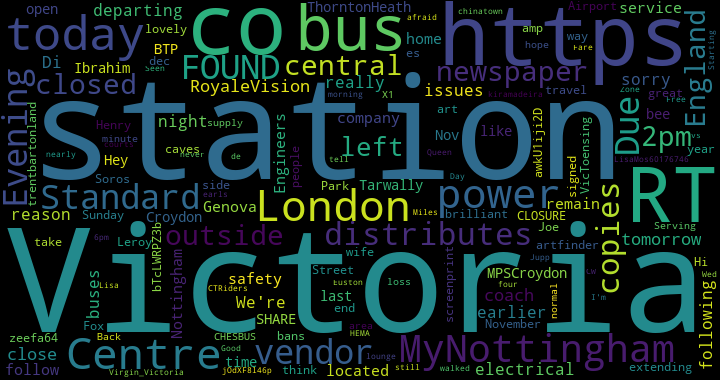

In [77]:
w2.to_image()

What can we hear from social media words?
Above wordmap as a PoC can use as social media radar to sense the story behind each word:

- Voice of '2pm': 
  RT @MyNottingham: We're really sorry but we have to close Victoria Centre bus station at 2pm today following earlier electrical issues. The…
Be aware! https://t.co/crkbBA3RV1
  RT @StagecoachEMid: #Mansfield Victoria Bus Station at Nottingham will close from 14:00 due to intermittent power failure. Pronto will use…
- Voice of 'Never'
   '@michael_merrick I hope daughters Japanese flat mates never encounter the toilets at Victoria coach station, they’l… https://t.co/FgW2GQvQlc',
-...